# Курсовий проект. Тема "Перегляд реклами"
* Метою цього проєкту є аналіз ефективності показу онлайн-реклами. 
* Основнa задача: Побудова моделі для прогнозування кількості переглядів залежно від часу, типу реклами та інших параметрів.

**Завдання**
1. **EDA (Exploratory Data Analysis)**:
   - Проаналізуйте дані на наявність трендів, сезонності та аномалій.   
   - Візуалізуйте дані (часові графіки, гістограми, теплові карти тощо).  

2. **Попередня обробка**:
   - Врахуйте аномалії у даних: визначте, чи потрібно їх видалити, згладити або моделювати окремо.

3. **Прогнозування**:
   - Використовуйте оброблені дані для створення моделі прогнозування на 7 днів наперед.  
   - Виберіть модель, яка враховує тренди та сезонність (наприклад, ARIMA, Prophet або LSTM).  

4. **Оцінка результатів**:
   - Перевірте якість прогнозу, використовуючи метрики (наприклад, RMSE, MAE).  
   - Інтерпретуйте отриманий прогноз і перевірте, як модель справляється з аномаліями.
  
Дані: набір містить інформацію про кількість перегрлядів реклами під час комп'ютерної гри. Дані агреговані погодинно.

# Виконання

#### Завантажуємо дані та спостерігаємо

In [111]:
import pandas as pd
data = pd.read_csv('data/ads.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

print(len(data))
data.head()

216


,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


Train data length: 168
Test data length: 48


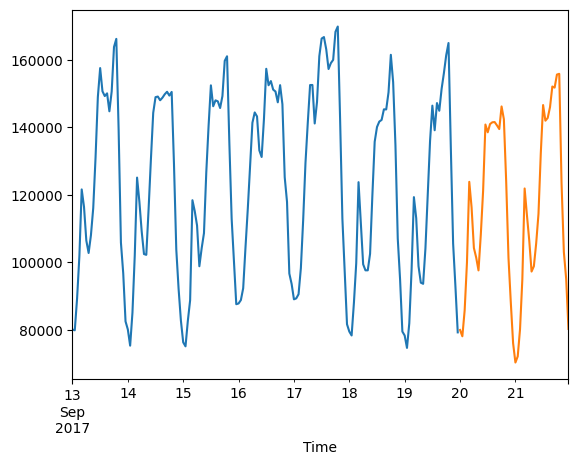

In [112]:
# Initial length = 216 = 24 * 9 -- 9 daily cycles
# Let the test dataset will be two cycles = 48 -- required for decomposition tool
train_test_size = 168

data_train = data[:train_test_size]
data_test = data[train_test_size:]

data_train['Ads'].plot()
data_test['Ads'].plot()
print(f"Train data length: {len(data_train)}")
print(f"Test data length: {len(data_test)}")

#### Аналізуємо дані
**Виявлені деталі**
* Дані рівномірні та без пропусків - передобробка не потрібна.
* Явний тренд відсутній - можна його не виділяти.
* Існує явно виражена сезонність, два рівня, більша - добова, та менша - приблизно 3-4 аплітуди на добу - необхідно їх виділити.

**Рішення**
* На всяк випадок зробимо ADF тест щоб впевнитися що ряд стаціонарний.
* Так як вже існує хоча б одна явно виражена компонента - треба виділити компоненти тренду, сезонності і шуму всі разом і проаналізувати їх окремо.

#### Перевіряємо ряд на стаціонарність

In [113]:
from statsmodels.tsa.stattools import adfuller
stability = adfuller(data_train.dropna())

print(f"ADF Statistic: {stability[0]:.8f}")
print(f"p-value: {stability[1]:.8f}")
print(f"Timeseries is", "STABLE" if stability[1] < 0.05 else "UNSTABLE")

ADF Statistic: -6.19627611
p-value: 0.00000006
Timeseries is STABLE


**Виявлені деталі**
* Ряд стаціонарний - диференціювати не потрібно

#### Виділяємо сезонність

<Axes: xlabel='Time'>

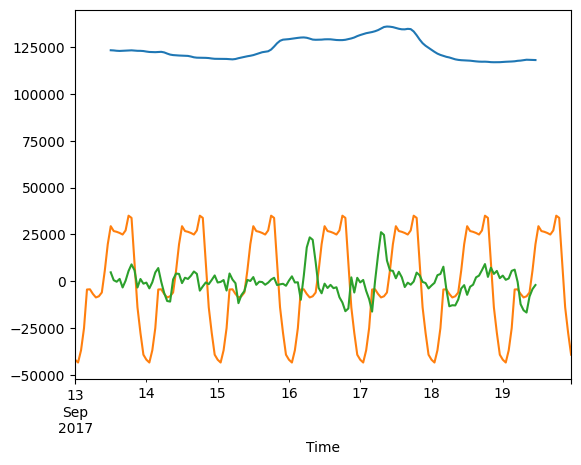

In [114]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition_result = seasonal_decompose(data_train, period=24)

decomposition_trend = decomposition_result.trend.dropna()
decomposition_seasonal = decomposition_result.seasonal.dropna()
decomposition_residuals = decomposition_result.resid.dropna()

decomposition_trend.plot()
decomposition_seasonal.plot()
decomposition_residuals.plot()

In [115]:
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

correlation = np.corrcoef(decomposition_trend, decomposition_residuals)[0, 1]
print(f"Кореляція між трендом і шумами: {correlation:.4f}")

Кореляція між трендом і шумами: 0.1906


Mean: -119.9457, Std: 7194.6607
       lb_stat     lb_pvalue
24  158.536707  8.453248e-22
Data is depended (is not noise): TRUE


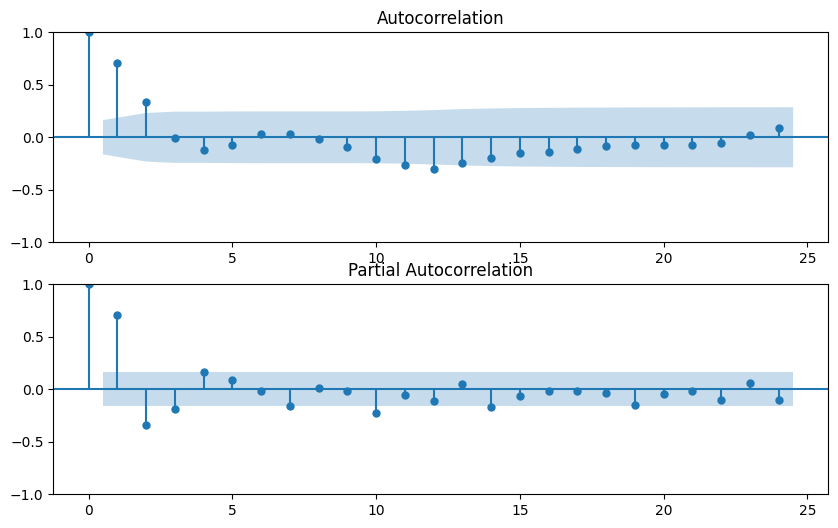

In [116]:
mean_residuals = decomposition_residuals.mean()
std_residuals = decomposition_residuals.std()
print(f"Mean: {mean_residuals:.4f}, Std: {std_residuals:.4f}")

from statsmodels.stats.diagnostic import acorr_ljungbox
lb_test = acorr_ljungbox(decomposition_residuals, lags=[24], return_df=True)
print(lb_test)
print("Data is depended (is not noise):", "TRUE" if lb_test["lb_pvalue"].values[0] < 0.05 else "FALSE")

fig, axes = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(decomposition_residuals, lags=24, ax=axes[0])
plot_pacf(decomposition_residuals, lags=24, ax=axes[1])
plt.show()

**Виявлені деталі**
* Сезонність дуже чітка і стабільна - можна застосувати метод Furier Transformation який чітко виділить гармоніки.
* Тренд - вже ж таки має неочікуванні скачки, є підозра що вони корелюють зі скачками на шумах, але кореляція це не підтвердила, тому розглядаємо їх окремо.
* Шуми не схожі на реальний шум - Ljung-Box тест це підтверджує (є залежність від попередніх значень) та mean != 0 що значить що є постійне зміщення - треба буде використовувати ARIMA для прогнозування. Визначемо параметри p, d, q. Ряд стаціонарний, тому d = 1 - не робимо диференціяцію. Автокореляція показує що лаг = 2 найбільше впливають на поточне значения, тому q = 2. Часткова автокореляція показує, що після перших двух значень різко падає кореляція, а тому 2й лаг це є той лаг з якого можно визначати авторегресію.
* Тренд може бути або просто аномалією або циклічним трендом який не видно в масштабі наданих даних (більше місяця). За допомогою Furier Transformation спробуємо отримати якусь одну вагому частоту - якщо буде - то це все ж таки сезонність, якщо ні - аномалія.

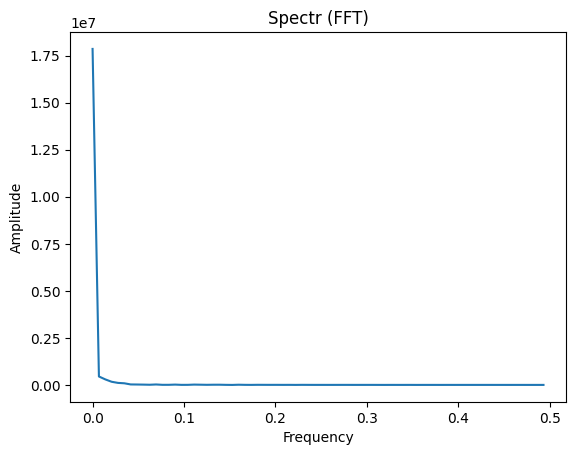

In [117]:
fft_result = np.fft.fft(decomposition_trend)
freqs = np.fft.fftfreq(len(decomposition_trend))

half_len = len(decomposition_trend) // 2 
plt.plot(freqs[:half_len], np.abs(fft_result)[:half_len])
plt.title("Spectr (FFT)")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

**Виявлені деталі**
* Частот виражених не має - це аномалія, ми її пронозувати не будемо і в якості тренда візьмемо його середнє значення для прогнозу 

#### Прогнозуємо компоненти

c:\MLCourse\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\MLCourse\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


DatetimeIndex(['2017-09-13 12:00:00', '2017-09-13 13:00:00',
               '2017-09-13 14:00:00', '2017-09-13 15:00:00',
               '2017-09-13 16:00:00', '2017-09-13 17:00:00',
               '2017-09-13 18:00:00', '2017-09-13 19:00:00',
               '2017-09-13 20:00:00', '2017-09-13 21:00:00',
               ...
               '2017-09-19 02:00:00', '2017-09-19 03:00:00',
               '2017-09-19 04:00:00', '2017-09-19 05:00:00',
               '2017-09-19 06:00:00', '2017-09-19 07:00:00',
               '2017-09-19 08:00:00', '2017-09-19 09:00:00',
               '2017-09-19 10:00:00', '2017-09-19 11:00:00'],
              dtype='datetime64[ns]', length=144, freq='h')
                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  144
Model:                 ARIMA(5, 0, 5)   Log Likelihood               -1348.953
Date:                Fri, 07 Feb 2025   AIC                           272

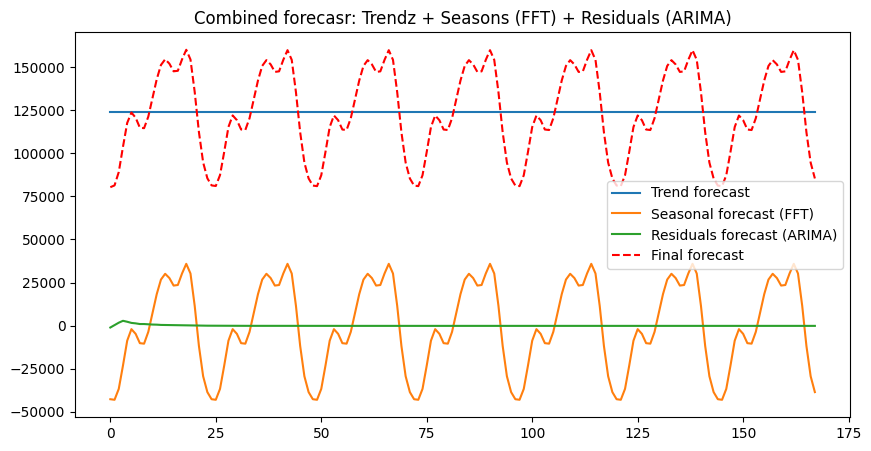

In [118]:
forecast_horizon = 24 * 7

# Trend
trend_mean = decomposition_trend.mean()
future_trend = np.full(forecast_horizon, trend_mean)

# Seasons
initial_data_len = len(decomposition_seasonal)
fft_result = np.fft.fft(decomposition_seasonal)
freqs = np.fft.fftfreq(initial_data_len)
top_k = 10
indices = np.argsort(np.abs(fft_result))[-top_k:]
filtered_fft = np.zeros_like(fft_result, dtype=complex)
filtered_fft[indices] = fft_result[indices]
extended_time = np.arange(initial_data_len + forecast_horizon)
future_seasonal = np.fft.ifft(filtered_fft).real[-forecast_horizon:]

# Residuals
decomposition_residuals = decomposition_residuals.copy() 
decomposition_residuals.index = pd.date_range(
    start=decomposition_residuals.index[0], periods=len(decomposition_residuals), freq="h"
)


from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
arima_model = ARIMA(
    decomposition_residuals, 
    order=(5, 0, 5), 
    enforce_stationarity=False
)
arima_result = arima_model.fit()
print(arima_result.model.data.dates)
print(arima_result.summary())
future_residuals = arima_result.forecast(steps=forecast_horizon)

final_forecast = future_trend + future_seasonal + future_residuals

plt.figure(figsize=(10, 5))
plt.plot(np.arange(forecast_horizon), future_trend, label="Trend forecast")
plt.plot(np.arange(forecast_horizon), future_seasonal, label="Seasonal forecast (FFT)")
plt.plot(np.arange(forecast_horizon), future_residuals, label="Residuals forecast (ARIMA)")
plt.plot(np.arange(forecast_horizon), final_forecast, label="Final forecast", linestyle="dashed", color="red")
plt.legend()
plt.title("Combined forecasr: Trendz + Seasons (FFT) + Residuals (ARIMA)")
plt.show()

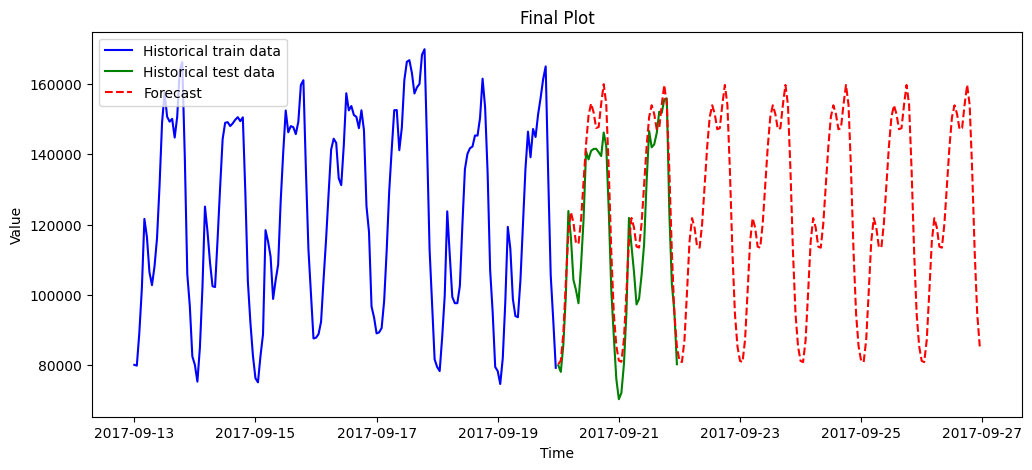

In [119]:
future_dates = pd.date_range(start=data_train.index[-1], periods=len(final_forecast)+1, freq='h')[1:]
plt.figure(figsize=(12, 5))
plt.plot(data_train.index, data_train['Ads'], label="Historical train data", color="blue")
plt.plot(data_test.index, data_test['Ads'], label="Historical test data", color="green")
plt.plot(future_dates, final_forecast, label="Forecast", linestyle="dashed", color="red")

plt.legend()
plt.title("Final Plot")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

MSE: 99473484.45
MAE: 8799.64


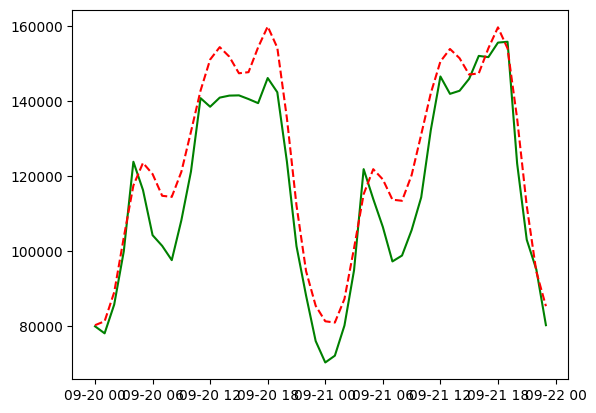

In [120]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

time_values = data_test.index
actual_values = data_test["Ads"]
predicted_values = final_forecast[:len(actual_values)]

mse = mean_squared_error(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")

plt.plot(time_values, actual_values, label="actual_values", color="green")
plt.plot(time_values, predicted_values, label="predicted_values", linestyle="dashed", color="red")
plt.show()

**Виявлені деталі**
* Підхід до пронозування тренду та сезонності вийшли вдалими, прогноз має правдоподібну структуру
* Щодо прогнозу залишків за допомогою ARIMA - при будь-яких параметрах виникає пряма лінія і вона баче її как шум і тому повертає константу. Поки мені не вдалося зрозуміти в чому справа - за допомогою чат-бота аналізую вивід summary моделі - модель тут наче розуміє що це просто шум. В рамках задачі прийму рішення що це непрогнозований шум, але в цілому подтрібно зрозуміти що не так і як діяти в цій ситуації.

### Спроба 2 - Prophet

In [121]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

pf_data = data.copy().reset_index() # Prophet does need index, it needs just a column "ts"
pf_data.columns = ["ds", "y"]
pf_data.head()

,ds,y
0,2017-09-13 00:00:00,80115
1,2017-09-13 01:00:00,79885
2,2017-09-13 02:00:00,89325
3,2017-09-13 03:00:00,101930
4,2017-09-13 04:00:00,121630


In [122]:
prophet_model = Prophet()
prophet_model.fit(pf_data)
prophet_future_time = prophet_model.make_future_dataframe(periods=24 * 7, freq="h")
prophet_forecast = prophet_model.predict(prophet_future_time)

19:15:52 - cmdstanpy - INFO - Chain [1] start processing
19:15:52 - cmdstanpy - INFO - Chain [1] done processing


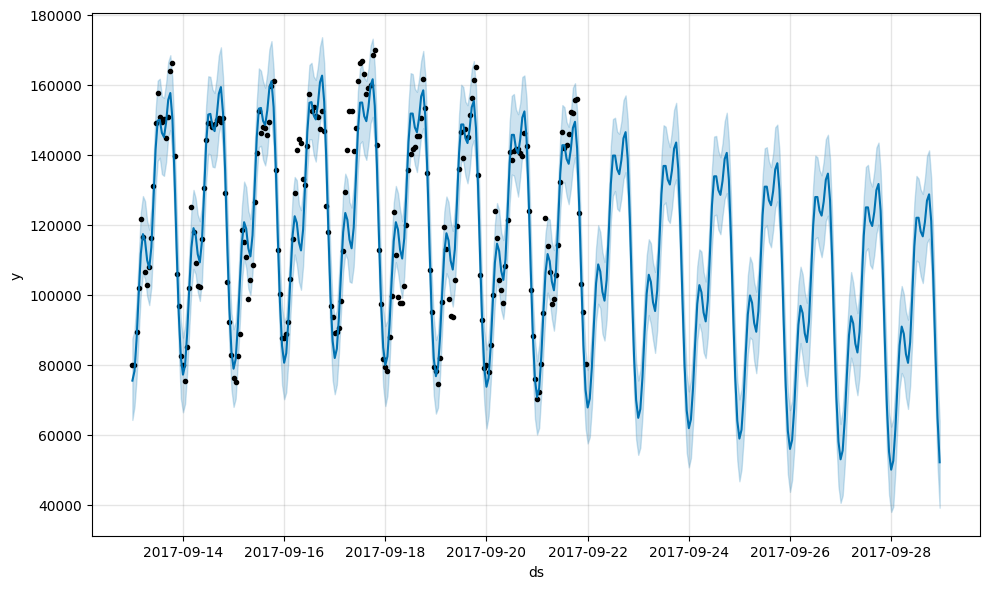

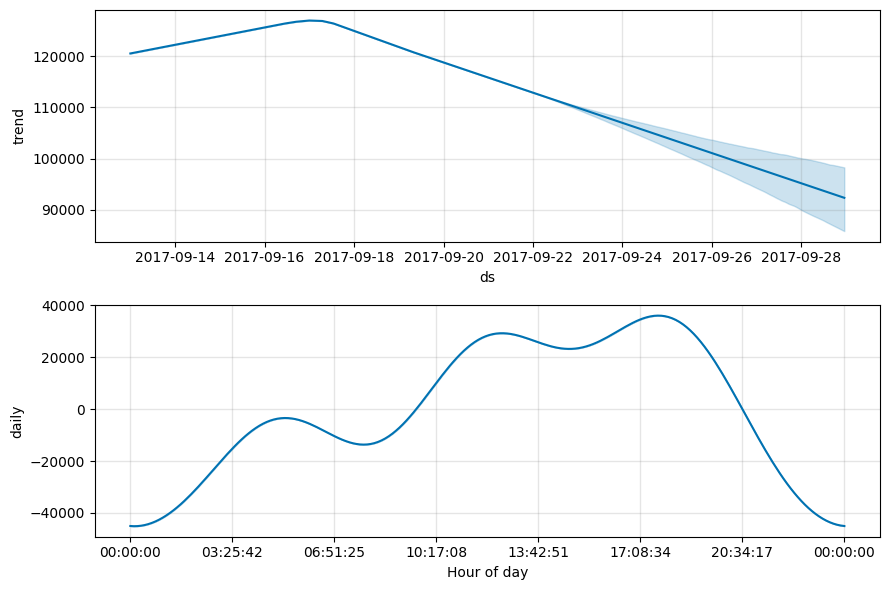

In [123]:
fig1 = prophet_model.plot(prophet_forecast)
fig2 = prophet_model.plot_components(prophet_forecast)
plt.show()

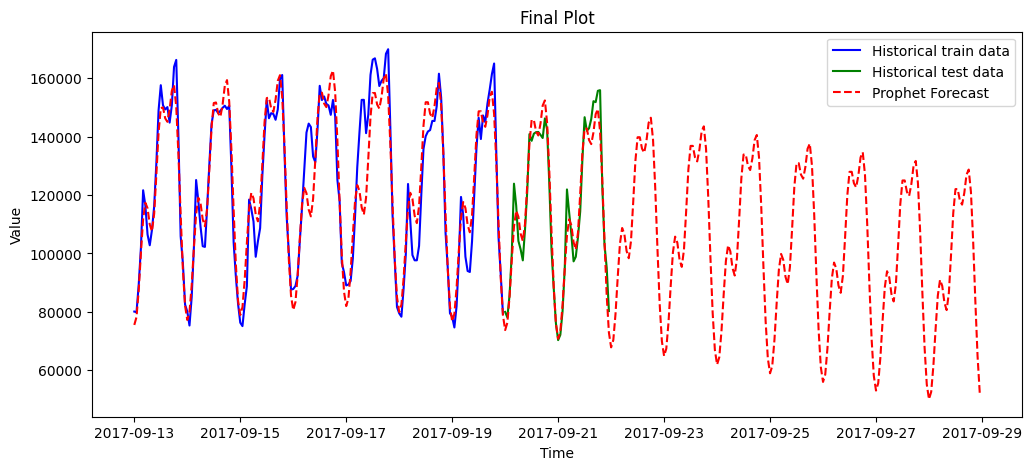

In [124]:
future_dates = pd.date_range(start=data_train.index[-1], periods=len(final_forecast)+1, freq='h')[1:]
plt.figure(figsize=(12, 5))
plt.plot(data_train.index, data_train['Ads'], label="Historical train data", color="blue")
plt.plot(data_test.index, data_test['Ads'], label="Historical test data", color="green")
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label="Prophet Forecast", linestyle="dashed", color="red")

plt.legend()
plt.title("Final Plot")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

In [125]:
df_cv = cross_validation(
    prophet_model, 
    initial='6 days',
    period='2 days', 
    horizon='2 days'
)
df_p = performance_metrics(df_cv)
print(f"MSE: {df_p['mse'].mean():,.2f}")
print(f"MAE: {df_p['mae'].mean():,.2f}")


  0%|          | 0/1 [00:00<?, ?it/s]19:15:53 - cmdstanpy - INFO - Chain [1] start processing
19:15:53 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:00<00:00,  8.16it/s]

MSE: 78,782,812.10
MAE: 6,735.15


MSE: 35740832.94
MAE: 4542.43


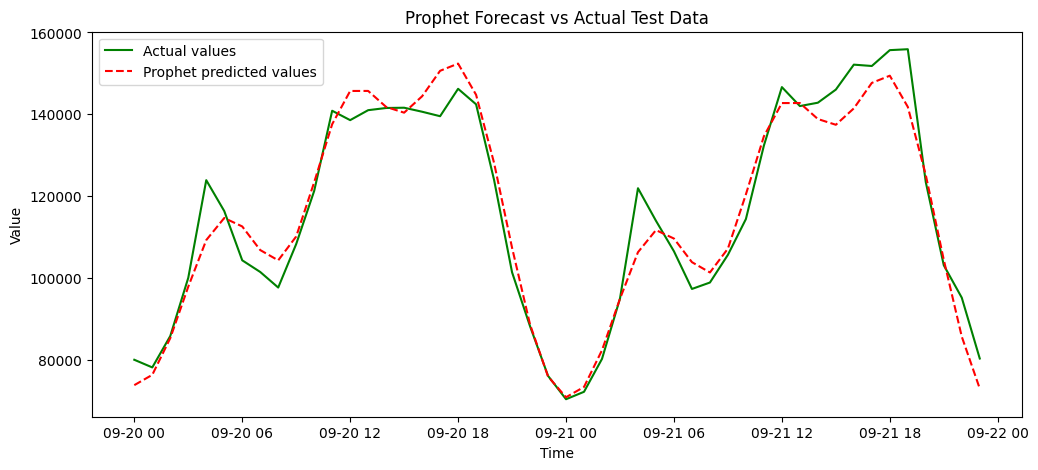

In [126]:
forecast_df = prophet_forecast.set_index('ds')
prophet_predicted_values = forecast_df.loc[data_test.index, 'yhat']

prophet_mse = mean_squared_error(actual_values, prophet_predicted_values)
prophet_mae = mean_absolute_error(actual_values, prophet_predicted_values)

print(f"MSE: {prophet_mse:.2f}")
print(f"MAE: {prophet_mae:.2f}")

plt.figure(figsize=(12, 5))
plt.plot(data_test.index, actual_values, label="Actual values", color="green")
plt.plot(data_test.index, prophet_predicted_values, label="Prophet predicted values", linestyle="dashed", color="red")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Prophet Forecast vs Actual Test Data")
plt.show()


**Виявлені деталі**
* Prophet розділив дані на дві компоненти - сезонність (така сама як і раніше було визначено) і кусково-лінійний тренд, де перелом відбувається там же де і в минулому разі було виявлено коливання тренду.
* Метрики MSE i MAE показують кращі метрики, але викликає занепокоєння щодо лінійного тренду, який опускає весь графік з часом - на практиці треба обов'язково це узгодити як тільки з'являться нові дані